# Conjugate Priors

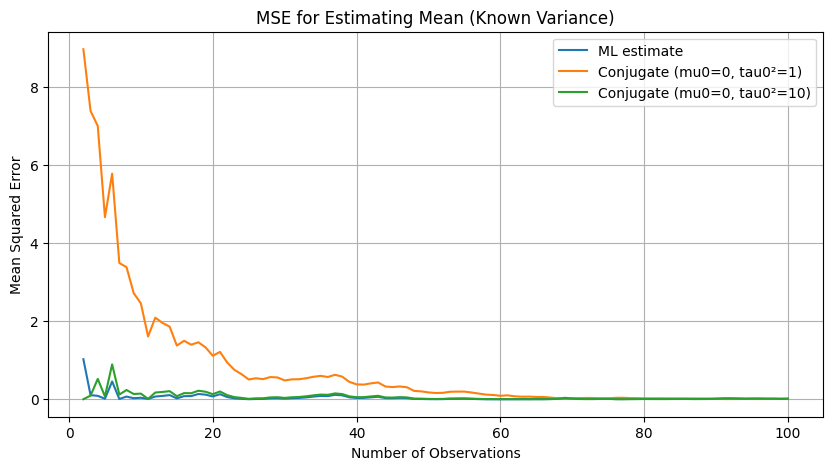

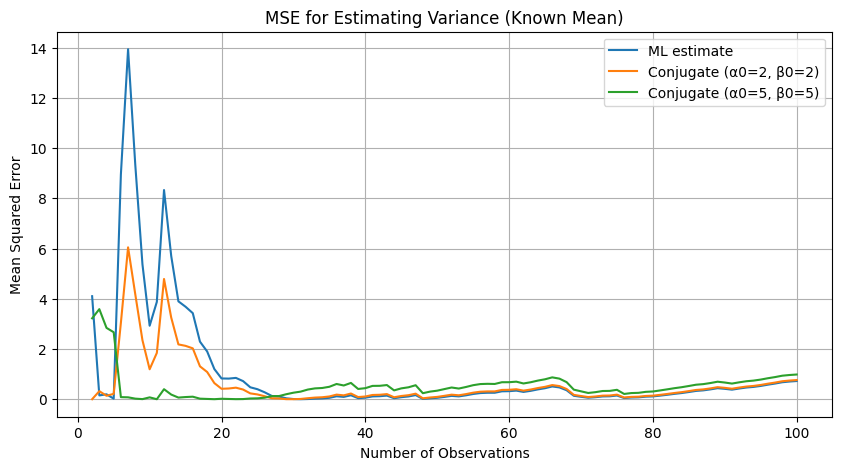

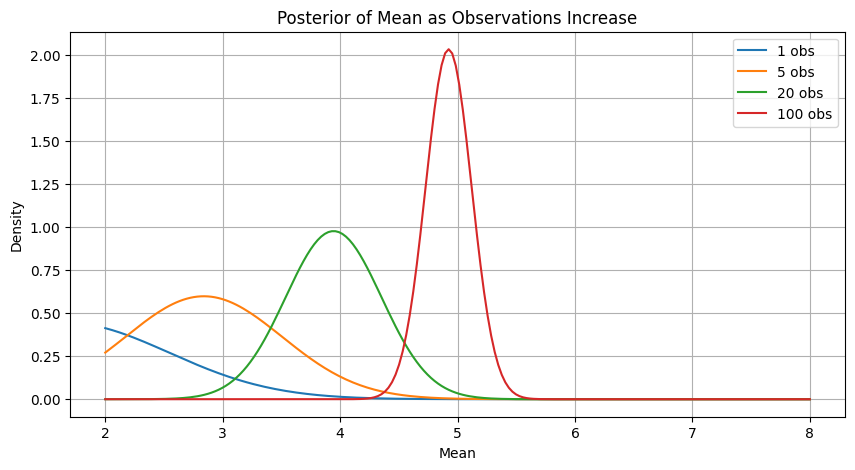

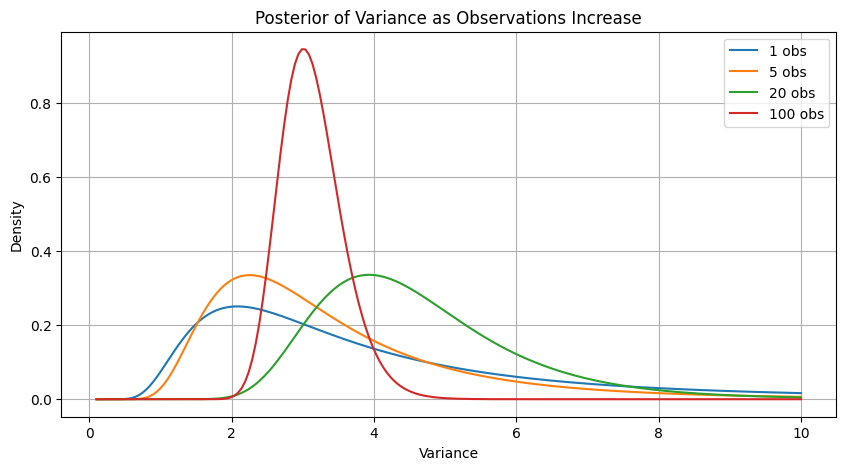

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display

np.random.seed(1)

#Parameters
true_mean = 5.0
true_variance = 4.0  # sigma^2 = 2^2
n_samples = 100
data = np.random.normal(true_mean, np.sqrt(true_variance), size=n_samples)

#Gaussian with known variance, Find Mean
def conjugate_mean_estimate(data, mu0, tau0_sq, sigma_sq):
    n = len(data)
    sample_mean = np.mean(data)
    tau_n_sq = 1 / (1 / tau0_sq + n / sigma_sq)
    mu_n = tau_n_sq * (mu0 / tau0_sq + n * sample_mean / sigma_sq)
    return mu_n, tau_n_sq

def ml_mean_estimate(data):
    return np.mean(data)

# Gaussian with known mean, find variance
def conjugate_variance_estimate(data, known_mean, alpha0, beta0):
    n = len(data)
    squared_diffs = np.sum((data - known_mean) ** 2)
    alpha_n = alpha0 + n / 2
    beta_n = beta0 + squared_diffs / 2
    return alpha_n, beta_n

def ml_variance_estimate(data, known_mean):
    return np.mean((data - known_mean) ** 2)

# Evaluate mean squared error(MSE) over varying sample n
def evaluate_estimators():
    sample_sizes = np.arange(2, n_samples + 1)
    
    #Known mean, uinkown variance
    hyperparams_mean = [(0, 1), (0, 10)]
    mse_ml_mean = []
    mse_conjugate_mean = [[] for _ in hyperparams_mean]

    #Calculate MSE 
    for n in sample_sizes:
        current_data = data[:n]
        ml_est = ml_mean_estimate(current_data)
        mse_ml_mean.append((ml_est - true_mean) ** 2)
        for i, (mu0, tau0_sq) in enumerate(hyperparams_mean):
            mu_n, _ = conjugate_mean_estimate(current_data, mu0, tau0_sq, true_variance)
            mse_conjugate_mean[i].append((mu_n - true_mean) ** 2)

    #plot MSE for known variance, unkown mean
    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, mse_ml_mean, label="ML estimate")
    for i, (mu0, tau0_sq) in enumerate(hyperparams_mean):
        label = f"Conjugate (mu0={mu0}, tau0²={tau0_sq})"
        plt.plot(sample_sizes, mse_conjugate_mean[i], label=label)
    plt.title("MSE for Estimating Mean (Known Variance)")
    plt.xlabel("Number of Observations")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True)
    plt.show()

    #known mean, unknown variance
    known_mean = true_mean
    hyperparams_var = [(2, 2), (5, 5)]
    mse_ml_var = []
    mse_conjugate_var = [[] for _ in hyperparams_var]

    #calculate MSE
    for n in sample_sizes:
        current_data = data[:n]
        ml_est = ml_variance_estimate(current_data, known_mean)
        mse_ml_var.append((ml_est - true_variance) ** 2)
        for i, (a0, b0) in enumerate(hyperparams_var):
            a_n, b_n = conjugate_variance_estimate(current_data, known_mean, a0, b0)
            posterior_mean = b_n / (a_n - 1) if a_n > 1 else np.inf
            mse_conjugate_var[i].append((posterior_mean - true_variance) ** 2)

    #plot MSE
    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, mse_ml_var, label="ML estimate")
    for i, (a0, b0) in enumerate(hyperparams_var):
        label = f"Conjugate (α0={a0}, β0={b0})"
        plt.plot(sample_sizes, mse_conjugate_var[i], label=label)
    plt.title("MSE for Estimating Variance (Known Mean)")
    plt.xlabel("Number of Observations")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True)
    plt.show()


# === Plot Posterior Evolution ===

def plot_posterior_mean_updates():
    sigma_sq = true_variance
    mu0 = 0
    tau0_sq = 1
    x_vals = np.linspace(true_mean - 3, true_mean + 3, 200)

    plt.figure(figsize=(10, 5))
    for n in [1, 5, 20, 100]:
        subset = data[:n]
        mu_n, tau_n_sq = conjugate_mean_estimate(subset, mu0, tau0_sq, sigma_sq)
        y = norm.pdf(x_vals, mu_n, np.sqrt(tau_n_sq))
        plt.plot(x_vals, y, label=f"{n} obs")
    plt.title("Posterior of Mean as Observations Increase")
    plt.xlabel("Mean")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_posterior_variance_updates():
    a0 = 2
    b0 = 2
    x_vals = np.linspace(0.1, 10, 200)
    known_mean = true_mean

    plt.figure(figsize=(10, 5))
    for n in [1, 5, 20, 100]:
        subset = data[:n]
        a_n, b_n = conjugate_variance_estimate(subset, known_mean, a0, b0)
        y = invgamma.pdf(x_vals, a_n, scale=b_n)
        plt.plot(x_vals, y, label=f"{n} obs")
    plt.title("Posterior of Variance as Observations Increase")
    plt.xlabel("Variance")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
evaluate_estimators()
plot_posterior_mean_updates()
plot_posterior_variance_updates()


# Stretch Goal 1 - Animation

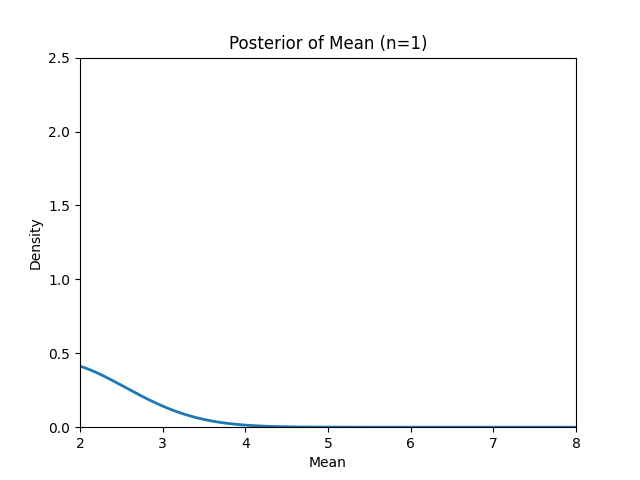

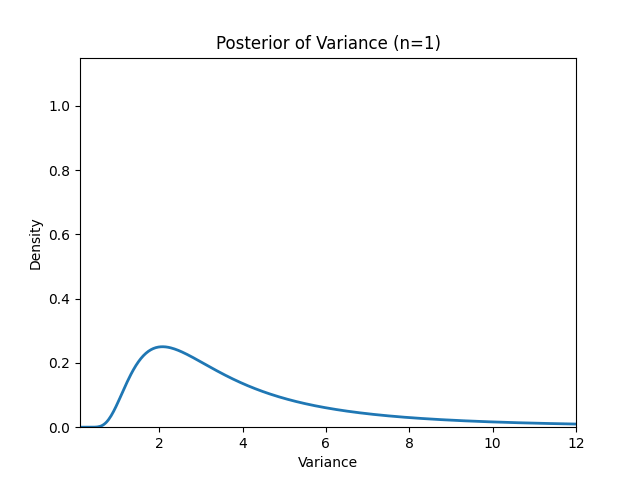

In [5]:
#create gif of known variance unkown mean
def animate_posterior_mean():
    mu0, tau0_sq = 0, 1
    sigma_sq = true_variance
    x_vals = np.linspace(true_mean - 3, true_mean + 3, 400)

    fig, ax = plt.subplots()
    line, = ax.plot([], [], lw=2)
    ax.set_xlim(x_vals[0], x_vals[-1])
    ax.set_ylim(0, 2.5)
    ax.set_title("Posterior of Mean (Normal Prior)")
    ax.set_xlabel("Mean")
    ax.set_ylabel("Density")

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        n = frame + 1
        subset = data[:n]
        sample_mean = np.mean(subset)
        tau_n_sq = 1 / (1 / tau0_sq + n / sigma_sq)
        mu_n = tau_n_sq * (mu0 / tau0_sq + n * sample_mean / sigma_sq)
        y_vals = norm.pdf(x_vals, mu_n, np.sqrt(tau_n_sq))
        line.set_data(x_vals, y_vals)
        ax.set_title(f"Posterior of Mean (n={n})")
        return line,

    anim = FuncAnimation(fig, update, frames=n_samples, init_func=init, blit=True)
    anim.save("Posterior_Mean_Convergence.gif", writer = 'pillow', fps=10)
    plt.close()

#create gif for known mean unknown variance
def animate_posterior_variance():
    alpha0, beta0 = 2, 2
    known_mean = true_mean
    x_vals = np.linspace(0.1, 12, 400)

    fig, ax = plt.subplots()
    line, = ax.plot([], [], lw=2)
    ax.set_xlim(x_vals[0], x_vals[-1])
    ax.set_ylim(0, 1.15)
    ax.set_title("Posterior of Variance (Inverse-Gamma Prior)")
    ax.set_xlabel("Variance")
    ax.set_ylabel("Density")

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        n = frame + 1
        subset = data[:n]
        squared_diffs = np.sum((subset - known_mean) ** 2)
        alpha_n = alpha0 + n / 2
        beta_n = beta0 + squared_diffs / 2
        y_vals = invgamma.pdf(x_vals, alpha_n, scale=beta_n)
        line.set_data(x_vals, y_vals)
        ax.set_title(f"Posterior of Variance (n={n})")
        return line,

    anim = FuncAnimation(fig, update, frames=n_samples, init_func=init, blit=True)
    anim.save("Posterior_Variance_Convergence.gif", writer = 'pillow', fps=10)
    plt.close()

animate_posterior_mean()
animate_posterior_variance()
display(Image(filename="Posterior_Mean_Convergence.gif"))
display(Image(filename="Posterior_Variance_Convergence.gif"))

# Stretch Goal 2 - Heatmaps

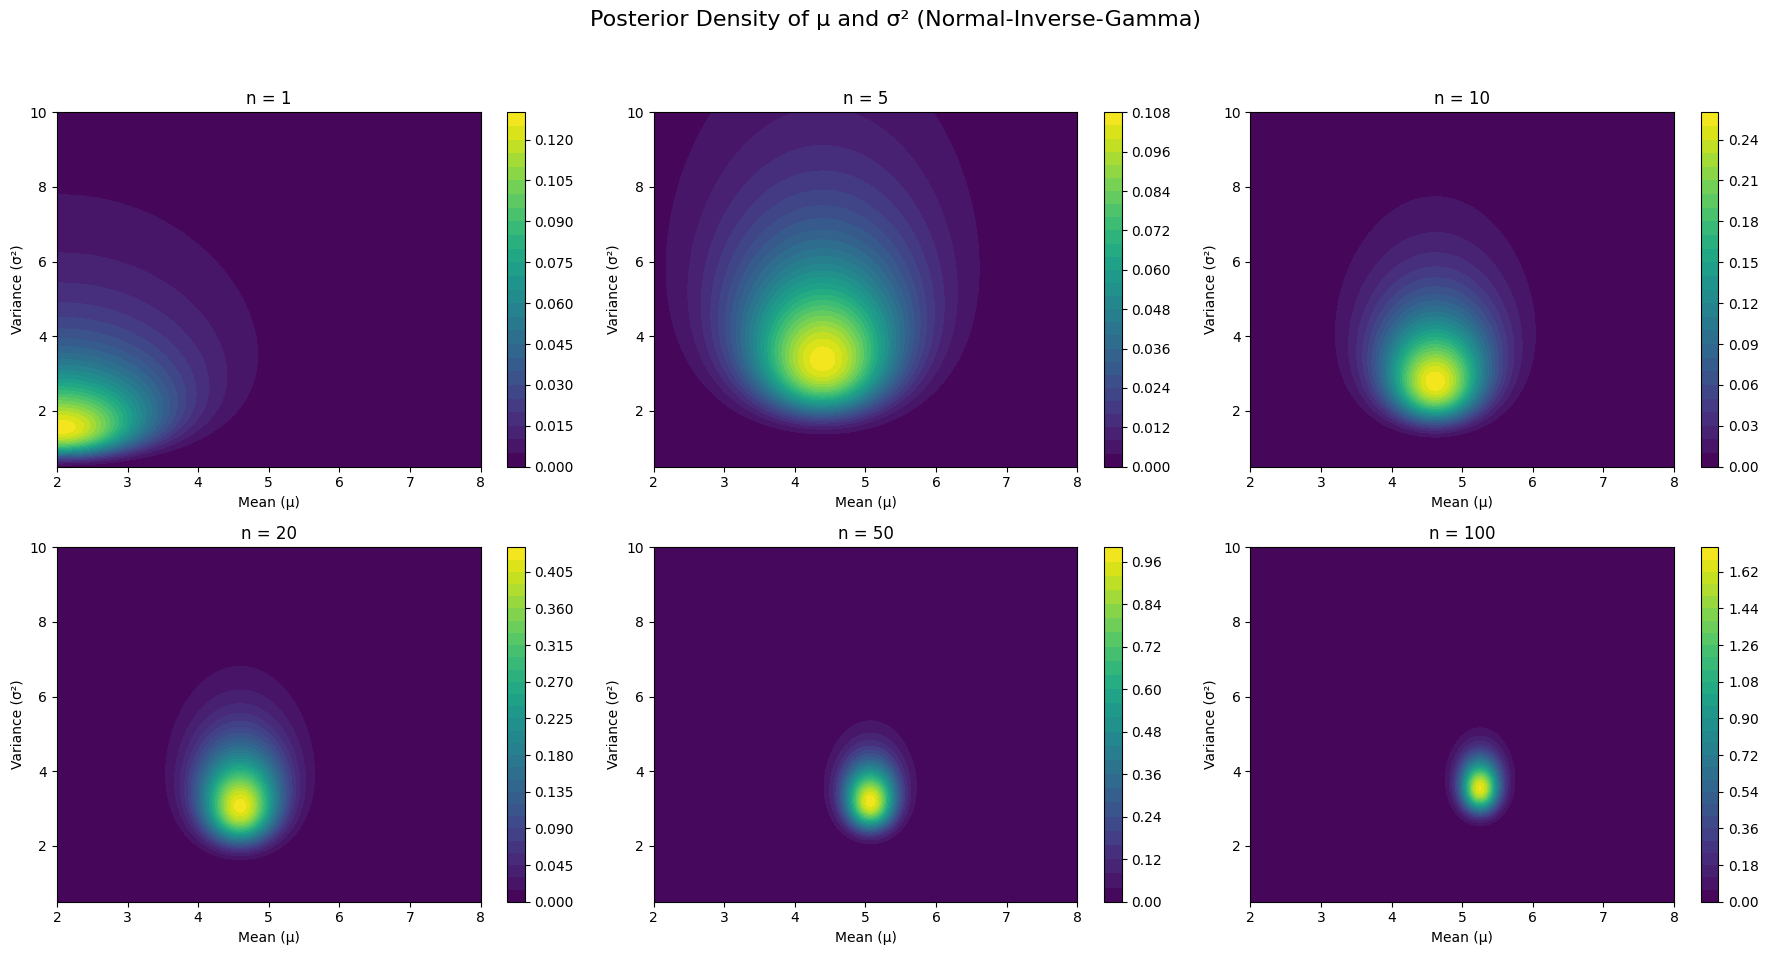

In [6]:
# True values and data
true_mu = 5
true_sigma2 = 4
data = np.random.normal(true_mu, np.sqrt(true_sigma2), n_samples)

# Prior hyperparameters
mu0 = 0
lambda0 = 1
alpha0 = 2
beta0 = 2

# Grid for plotting
mu_vals = np.linspace(true_mu - 3, true_mu + 3, 200)
sigma2_vals = np.linspace(0.5, 10, 200)
MU, SIGMA2 = np.meshgrid(mu_vals, sigma2_vals)

def normal_inv_gamma_pdf(mu, sigma2, mu0, lambda_, alpha, beta):
    """Compute the joint Normal-Inverse-Gamma PDF."""
    norm_part = norm.pdf(mu, loc=mu0, scale=np.sqrt(sigma2 / lambda_))
    invgamma_part = invgamma.pdf(sigma2, a=alpha, scale=beta)
    return norm_part * invgamma_part

def update_posterior(data, mu0, lambda0, alpha0, beta0):
    n = len(data)
    if n == 0:
        return mu0, lambda0, alpha0, beta0
    x_bar = np.mean(data)
    ssq = np.sum((data - x_bar) ** 2)
    lambda_n = lambda0 + n
    mu_n = (lambda0 * mu0 + n * x_bar) / lambda_n
    alpha_n = alpha0 + n / 2
    beta_n = beta0 + 0.5 * ssq + (lambda0 * n * (x_bar - mu0) ** 2) / (2 * lambda_n)
    return mu_n, lambda_n, alpha_n, beta_n

# Plot posterior evolution
steps = [1, 5, 10, 20, 50, 100]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, n in enumerate(steps):
    mu_n, lambda_n, alpha_n, beta_n = update_posterior(data[:n], mu0, lambda0, alpha0, beta0)
    pdf_vals = normal_inv_gamma_pdf(MU, SIGMA2, mu_n, lambda_n, alpha_n, beta_n)
    
    ax = axes[i]
    im = ax.contourf(MU, SIGMA2, pdf_vals, levels=30, cmap="viridis")
    ax.set_title(f"n = {n}")
    ax.set_xlabel("Mean (μ)")
    ax.set_ylabel("Variance (σ²)")
    fig.colorbar(im, ax=ax)

plt.suptitle("Posterior Density of μ and σ² (Normal-Inverse-Gamma)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
